Using device: cuda

=== Fold 1/5 ===

=== Fold 2/5 ===

=== Fold 3/5 ===

=== Fold 4/5 ===

=== Fold 5/5 ===

K-Fold CV  Mean Acc: 0.6862, Std: 0.0052

Test Metrics:
Accuracy : 0.6906
F1 Score : 0.6818
Precision: 0.7031
Recall   : 0.6619
AUC      : 0.7550


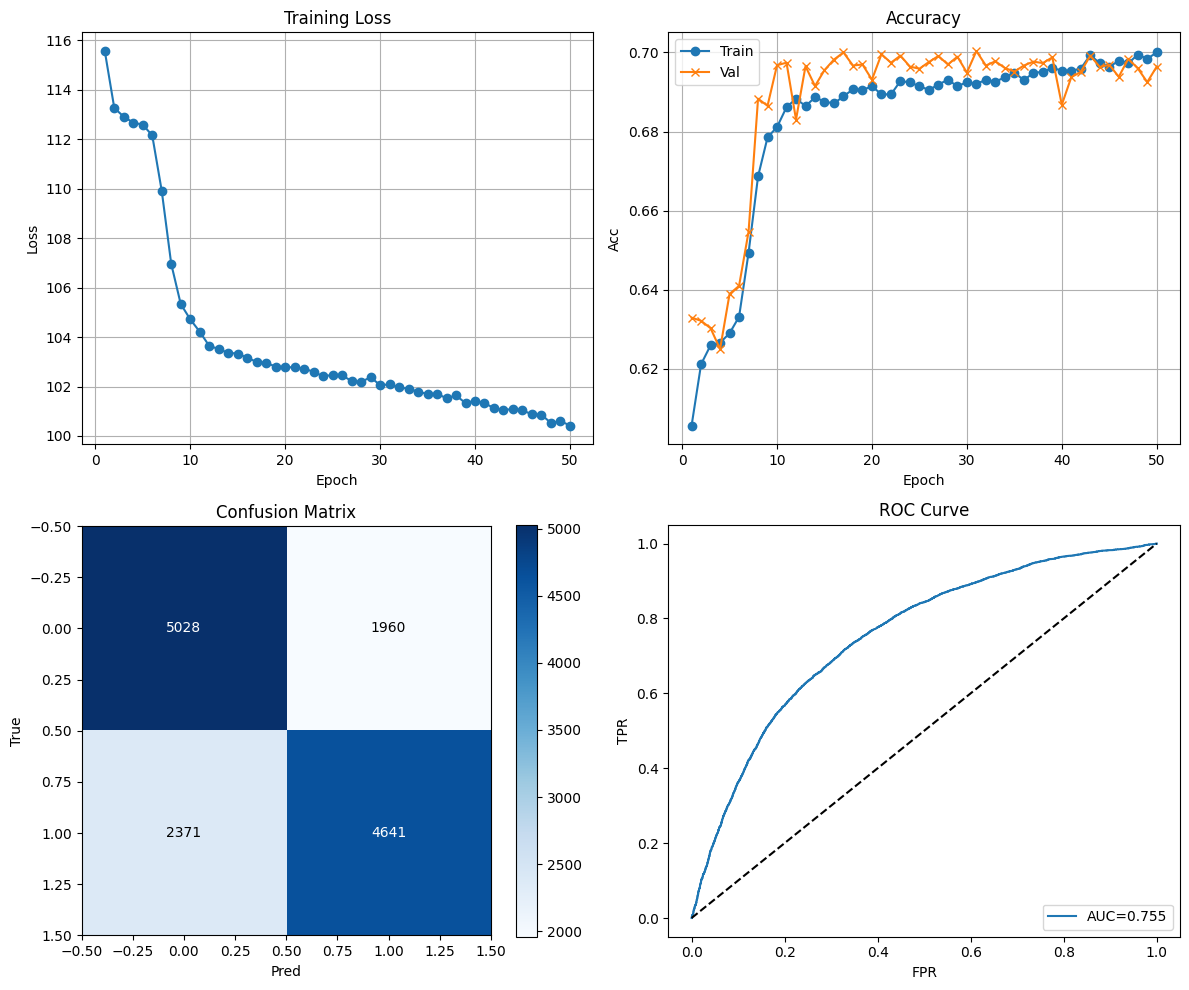

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, roc_auc_score, roc_curve,
    confusion_matrix
)
from torch.utils.data import Dataset, DataLoader
from tab_transformer_pytorch import TabTransformer

# ── 設定 ───────────────────────────────────
EPOCHS     = 50
THRESHOLD  = 0.73
BATCH_SIZE = 256
K_FOLDS    = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ── データ読み込み & 前処理 ─────────────────
data = pd.read_csv("cardio_train.csv", sep=';')
data['age_years'] = (data['age'] / 365).astype(int)

categorical_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
continuous_cols  = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo']
target_col       = 'cardio'

# Encode & scale
le = LabelEncoder()
for col in categorical_cols:
    data[col] = le.fit_transform(data[col])

scaler = StandardScaler()
data[continuous_cols] = scaler.fit_transform(data[continuous_cols])

# ── Dataset ─────────────────────────────────
class CardioDataset(Dataset):
    def __init__(self, df):
        self.X_cat = df[categorical_cols].values.astype(np.int64)
        self.X_cont= df[continuous_cols].values.astype(np.float32)
        self.y     = df[target_col].values.astype(np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X_cat[idx], dtype=torch.int64),
            torch.tensor(self.X_cont[idx], dtype=torch.float32),
            torch.tensor(self.y[idx],     dtype=torch.float32)
        )

# ── 関数定義 ───────────────────────────────
def train_with_validation(model, train_loader, val_loader, epochs, thresh):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    losses, train_accs, val_accs = [], [], []

    for epoch in range(1, epochs+1):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        for x_cat, x_cont, y in train_loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x_cat, x_cont).squeeze(1)
            loss   = criterion(logits, y)
            loss.backward(); optimizer.step()
            total_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).int()
            correct += (preds == y.int()).sum().item(); total += y.size(0)

        losses.append(total_loss)
        train_accs.append(correct/total)

        # validation
        model.eval()
        v_preds, v_trues = [], []
        with torch.no_grad():
            for xc, xcnt, yv in val_loader:
                xc, xcnt, yv = xc.to(device), xcnt.to(device), yv.to(device)
                out = model(xc, xcnt).squeeze(1)
                v_preds.extend(((torch.sigmoid(out)>0.5).int().cpu().tolist()))
                v_trues.extend(yv.int().cpu().tolist())
        val_acc = accuracy_score(v_trues, v_preds)
        val_accs.append(val_acc)

        if val_acc >= thresh:
            break

    return losses, train_accs, val_accs

def evaluate_model(model, loader):
    model.eval()
    preds, trues, probs = [], [], []
    with torch.no_grad():
        for x_cat, x_cont, y in loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
            logit = model(x_cat, x_cont).squeeze(1)
            prob  = torch.sigmoid(logit)
            preds.extend((prob>0.5).int().cpu().tolist())
            trues.extend(y.int().cpu().tolist())
            probs.extend(prob.cpu().tolist())

    print("\nTest Metrics:")
    print(f"Accuracy : {accuracy_score(trues, preds):.4f}")
    print(f"F1 Score : {f1_score(trues, preds):.4f}")
    print(f"Precision: {precision_score(trues, preds):.4f}")
    print(f"Recall   : {recall_score(trues, preds):.4f}")
    print(f"AUC      : {roc_auc_score(trues, probs):.4f}")

def plot_all_metrics(losses, train_accs, val_accs, model, loader, save_path):
    # gather test predictions
    preds, trues, probs = [], [], []
    model.eval()
    with torch.no_grad():
        for xc, xcnt, y in loader:
            xc, xcnt, y = xc.to(device), xcnt.to(device), y.to(device)
            out = model(xc, xcnt).squeeze(1)
            p   = torch.sigmoid(out)
            preds.extend((p>0.5).int().cpu().tolist())
            trues.extend(y.int().cpu().tolist())
            probs.extend(p.cpu().tolist())

    cm  = confusion_matrix(trues, preds)
    fpr, tpr, _ = roc_curve(trues, probs)
    auc = roc_auc_score(trues, probs)

    fig, axs = plt.subplots(2, 2, figsize=(12,10))
    epochs = range(1, len(losses)+1)

    # Training Loss
    axs[0,0].plot(epochs, losses, marker='o')
    axs[0,0].set(title="Training Loss", xlabel="Epoch", ylabel="Loss")
    axs[0,0].grid()

    # Accuracy
    axs[0,1].plot(epochs, train_accs, marker='o', label="Train")
    axs[0,1].plot(epochs, val_accs,   marker='x', label="Val")
    axs[0,1].set(title="Accuracy", xlabel="Epoch", ylabel="Acc")
    axs[0,1].legend(); axs[0,1].grid()

    # Confusion Matrix
    im = axs[1,0].imshow(cm, cmap="Blues")
    axs[1,0].set(title="Confusion Matrix", xlabel="Pred", ylabel="True")
    for (i,j), v in np.ndenumerate(cm):
        color = "white" if v>cm.max()/2 else "black"
        axs[1,0].text(j, i, v, ha="center", va="center", color=color)
    fig.colorbar(im, ax=axs[1,0])

    # ROC Curve
    axs[1,1].plot(fpr, tpr, label=f"AUC={auc:.3f}"); axs[1,1].plot([0,1],[0,1],"k--")
    axs[1,1].set(title="ROC Curve", xlabel="FPR", ylabel="TPR")
    axs[1,1].legend(loc="lower right")

    plt.tight_layout()
    fig.savefig(save_path, dpi=300)
    plt.show()

# ── データ準備 ─────────────────────────────
train_val, test = train_test_split(data, test_size=0.2, random_state=42)
test_loader = DataLoader(CardioDataset(test), batch_size=BATCH_SIZE, shuffle=False)

# ── K-Fold CV ───────────────────────────────
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
fold_scores = []
for fold, (tr_idx, val_idx) in enumerate(kf.split(train_val), 1):
    print(f"\n=== Fold {fold}/{K_FOLDS} ===")
    tr_df, v_df = train_val.iloc[tr_idx], train_val.iloc[val_idx]
    tr_loader = DataLoader(CardioDataset(tr_df), BATCH_SIZE, shuffle=True)
    v_loader  = DataLoader(CardioDataset(v_df), BATCH_SIZE, shuffle=False)

    # model
    cms = torch.tensor([[0.,1.]]*len(continuous_cols)).to(device)
    m = TabTransformer(
        categories=tuple(data[c].nunique() for c in categorical_cols),
        num_continuous=len(continuous_cols),
        dim=32, dim_out=1, depth=4, heads=4,
        attn_dropout=0.1, ff_dropout=0.1,
        mlp_hidden_mults=(4,2), mlp_act=nn.ReLU(),
        continuous_mean_std=cms
    ).to(device)
    m.categories_offset = m.categories_offset.to(device)

    _,_,v_accs = train_with_validation(m, tr_loader, v_loader, EPOCHS, THRESHOLD)
    fold_scores.append(v_accs[-1])

print(f"\nK-Fold CV  Mean Acc: {np.mean(fold_scores):.4f}, Std: {np.std(fold_scores):.4f}")

# ── 最終モデル学習 & 評価 ───────────────────
ft_df, fv_df = train_test_split(train_val, test_size=0.2, random_state=42)
ft_loader    = DataLoader(CardioDataset(ft_df), batch_size=BATCH_SIZE, shuffle=True)
fv_loader    = DataLoader(CardioDataset(fv_df), batch_size=BATCH_SIZE, shuffle=False)

cms = torch.tensor([[0.,1.]]*len(continuous_cols)).to(device)
final_model = TabTransformer(
    categories=tuple(data[c].nunique() for c in categorical_cols),
    num_continuous=len(continuous_cols),
    dim=32, dim_out=1, depth=4, heads=4,
    attn_dropout=0.1, ff_dropout=0.1,
    mlp_hidden_mults=(4,2), mlp_act=nn.ReLU(),
    continuous_mean_std=cms
).to(device)
final_model.categories_offset = final_model.categories_offset.to(device)

losses, train_accs, val_accs = train_with_validation(
    final_model, ft_loader, fv_loader, EPOCHS, THRESHOLD
)

evaluate_model(final_model, test_loader)
plot_all_metrics(losses, train_accs, val_accs, final_model, test_loader,
                save_path=f"output2/nomask_epoch{EPOCHS}.png")
